# Numpyro Integration

In [1]:
# @title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install git+https://github.com/thomaspinder/GPJax.git#egg=GPJax")

In [2]:
%load_ext lab_black

import gpjax
from gpjax.types import Dataset
import numpyro
import jax
import jax.numpy as jnp
import jax.random as jr
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
from jax import grad, jit

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

tfd = tfp.distributions
key = jr.PRNGKey(123)
print(gpjax.__version__)
from pprint import pprint

%matplotlib inline
%load_ext autoreload
%autoreload 2

0.3.3


## Data

In [3]:
N = 50
noise = 0.2

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

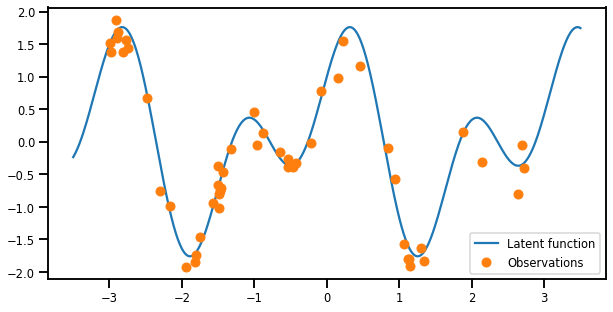

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.plot(x, y, "o", label="Observations", color="tab:orange")
ax.legend(loc="best")
plt.show()

## Gaussian Process Regression Model

In [5]:
from gpjax.gps import Prior
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian


kernel = RBF()
prior = Prior(kernel=kernel)

lik = Gaussian()
posterior = prior * lik

### Initialize Parameters

In [6]:
from gpjax.parameters import initialise

params = initialise(posterior)

print(params)

{'lengthscale': DeviceArray([1.], dtype=float64), 'obs_noise': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}


### Numpyro Style Parameters

In [7]:
from gpjax.interfaces.numpyro import add_constraints, numpyro_dict_params

In [8]:
numpyro_params = numpyro_dict_params(params)
pprint(numpyro_params)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6294f07c0>,
                 'init_value': DeviceArray([1.], dtype=float64),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6294f07c0>,
               'init_value': DeviceArray([1.], dtype=float64),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6294f07c0>,
              'init_value': DeviceArray([1.], dtype=float64),
              'param_type': 'param'}}


### Adding Constraints

We can modify the parameters such that there are constraints.

#### Example I - All Positive

In [9]:
from numpyro.distributions import constraints

# example 1 - adding positive for everything
numpyro_params_ = add_constraints(numpyro_params, constraints.real)
numpyro_params_

{'lengthscale': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7fe6294f08e0>},
 'obs_noise': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7fe6294f08e0>},
 'variance': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._Real at 0x7fe6294f08e0>}}

#### Example II - A specific Variable Real

In [10]:
# example 1 - adding positive for everything
numpyro_params_ = add_constraints(numpyro_params, "lengthscale", constraints.positive)
numpyro_params_

{'lengthscale': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7fe6294f07c0>},
 'obs_noise': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7fe6e448d520>},
 'variance': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7fe6e448d520>}}

#### Example III - 1 interval, 1 greater than 

In [11]:
# example 1 - adding positive for everything
new_constraints = {
    "lengthscale": constraints.greater_than(0.01),
    "obs_noise": constraints.interval(0.1, 0.001),
}

numpyro_params_ = add_constraints(numpyro_params, new_constraints)
# pprint(numpyro_params)
pprint(numpyro_params_)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe62427c970>,
                 'init_value': array([1.]),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._Interval object at 0x7fe62427c9d0>,
               'init_value': array([1.]),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe62427c7f0>,
              'init_value': array([1.]),
              'param_type': 'param'}}


## Maximum Likelihood Estimation

### Model

In [12]:
from numpyro.infer.autoguide import AutoDelta
from gpjax.interfaces.numpyro import numpyro_marginal_ll

# initialize parameters
params = initialise(posterior)
# convert to numpyro-style params
numpyro_params = numpyro_dict_params(params)

# initialize numpyro-style GP model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

# approximate posterior
guide = lambda x, y: None

# Delta Guide
guide = AutoDelta(npy_model)

In [13]:
from gpjax.types import Dataset

training_ds = Dataset(X=x, y=y)

In [14]:
with numpyro.handlers.seed(rng_seed=123):
    t_ = npy_model(training_ds)
    print(t_.shape)
    assert t_.shape[0] == x.shape[0]
    t = numpyro.handlers.trace(npy_model).get_trace(training_ds)

list(t.keys())

(50,)


['lengthscale', 'obs_noise', 'variance', 'y']

### Optimization

In [15]:
%%time
from numpyro.infer import SVI, Trace_ELBO

# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 2_500


# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), n_iterations, training_ds)

100%|██████████| 2500/2500 [00:04<00:00, 529.81it/s, init loss: 3273.3523, avg. loss [2376-2500]: 866.9415]


CPU times: user 15.9 s, sys: 1min 34s, total: 1min 50s
Wall time: 6.19 s


### Plotting the Loss

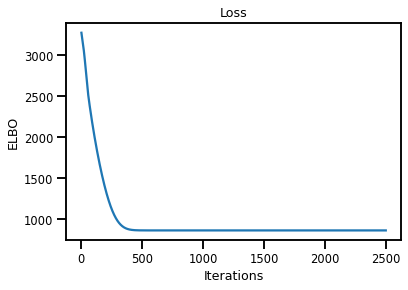

In [16]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="ELBO")
plt.show()

### Extracting the Parameters

In [17]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale': DeviceArray([0.4268455], dtype=float64),
 'obs_noise': DeviceArray([0.03674606], dtype=float64),
 'variance': DeviceArray([1.23430812], dtype=float64)}


### Predictions

In [18]:
from gpjax import mean, variance

meanf = mean(posterior, learned_params, training_ds)
varf = variance(posterior, learned_params, training_ds)


mu = meanf(xtest).squeeze()
cov = varf(xtest).squeeze()

one_stddev = 1.96 * jnp.sqrt(jnp.diag(cov))

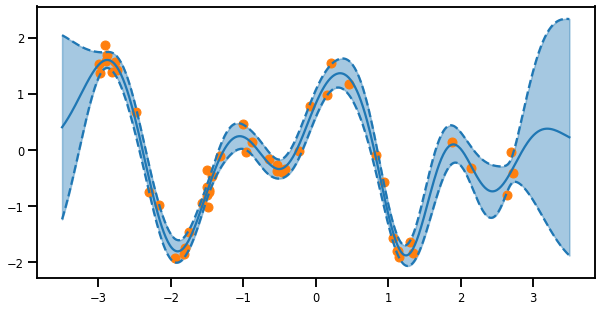

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

## Maximum A Posteriori

### Prior Parameters

In [20]:
import numpyro.distributions as dist

hyperpriors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.HalfCauchy(scale=1.0),
    "obs_noise": dist.HalfCauchy(scale=5.0),
}

#### Example I - Add a Prior

In [21]:
from gpjax.interfaces.numpyro import add_priors

numpyro_params = numpyro_dict_params(params)
numpyro_params_ = add_priors(numpyro_params, "lengthscale", dist.Gamma(1.0, 1.0))
pprint(numpyro_params_)

{'lengthscale': {'param_type': 'prior',
                 'prior': <numpyro.distributions.continuous.Gamma object at 0x7fe6240ad700>},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6240add00>,
               'init_value': array([1.]),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6240add00>,
              'init_value': array([1.]),
              'param_type': 'param'}}


#### Example II - Add Multiple Priors

In [22]:
from gpjax.interfaces.numpyro import add_priors

numpyro_params = numpyro_dict_params(params)
pprint(numpyro_params)
numpyro_params = add_priors(numpyro_params, hyperpriors)
pprint(numpyro_params)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6294f07c0>,
                 'init_value': DeviceArray([1.], dtype=float64),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6294f07c0>,
               'init_value': DeviceArray([1.], dtype=float64),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fe6294f07c0>,
              'init_value': DeviceArray([1.], dtype=float64),
              'param_type': 'param'}}
{'lengthscale': {'param_type': 'prior',
                 'prior': <numpyro.distributions.continuous.Gamma object at 0x7fe61c6de670>},
 'obs_noise': {'param_type': 'prior',
               'prior': <numpyro.distributions.continuous.HalfCauchy object at 0x7fe61c6de130>},
 'variance': {'param_type': 'prior',
              'prior': <numpyro.distributions.continuous.HalfCauchy objec

In [23]:
from gpjax import Dataset

training_ds = Dataset(X=x, y=y)

### GP Model

In [24]:
# initialize mle model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

# Delta Guide
guide = AutoDelta(npy_model)

In [25]:
with numpyro.handlers.seed(rng_seed=123):
    t = npy_model(training_ds)

### Optimization

In [26]:
%%time
from numpyro.infer import SVI, Trace_ELBO


# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 1_000

# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(rng_key, n_iterations, training_ds)

100%|██████████| 1000/1000 [00:02<00:00, 402.91it/s, init loss: 4464.1733, avg. loss [951-1000]: 870.8024]


CPU times: user 9.78 s, sys: 43.5 s, total: 53.3 s
Wall time: 5.25 s


### Losses

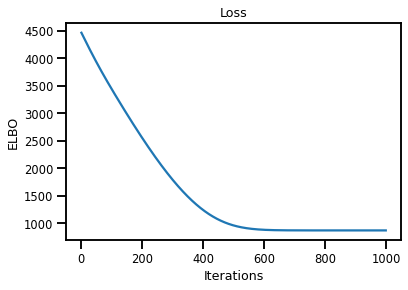

In [27]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="ELBO")
plt.show()

### Extracting the Parameters

In [28]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale_auto_loc': DeviceArray(0.42623758, dtype=float64),
 'obs_noise_auto_loc': DeviceArray(0.03674984, dtype=float64),
 'variance_auto_loc': DeviceArray(1.22620777, dtype=float64)}


In [29]:
# Take them directly
median_params = guide.median(learned_params)
pprint(median_params)

{'lengthscale': DeviceArray(0.42623758, dtype=float64),
 'obs_noise': DeviceArray(0.03674984, dtype=float64),
 'variance': DeviceArray(1.22620777, dtype=float64)}


We can also take the median which will eliminate the need for the `auto_loc` names.

### Predictions

In [30]:
from gpjax import mean, variance

meanf = mean(posterior, median_params, training_ds)
varf = variance(posterior, median_params, training_ds)


mu = meanf(xtest).squeeze()
cov = varf(xtest).squeeze()

one_stddev = 1.96 * jnp.sqrt(jnp.diag(cov))

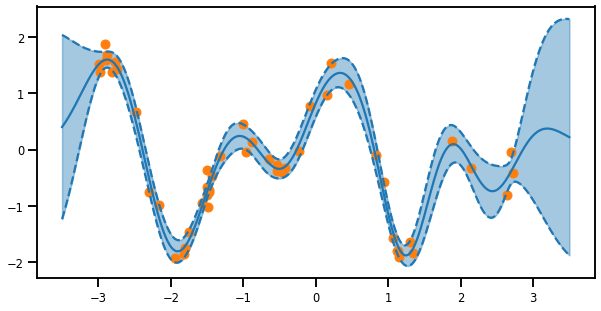

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

## Hamiltonian Monte Carlo

### Model

In [32]:
hyperpriors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.HalfCauchy(scale=1.0),
    "obs_noise": dist.HalfCauchy(scale=5.0),
}

numpyro_params = numpyro_dict_params(hyperpriors)

# initialize mle model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

### Sampling

Since we are doing sampling, there is no need to define a variational distribution.

In [33]:
# from chex import dataclass
# from gpjax.types import Dataset


training_ds = Dataset(X=x, y=y)

In [34]:
from numpyro.infer import MCMC, NUTS


# reproducibility
rng_key = jax.random.PRNGKey(0)

# NUTS Parameters
n_samples = 1_000
n_warmup = 100
# Setup
kernel = NUTS(npy_model)

nuts_sampling = MCMC(kernel, num_samples=n_samples, num_warmup=n_warmup)
nuts_sampling.run(rng_key, training_ds)

sample: 100%|██████████| 1100/1100 [00:10<00:00, 101.40it/s, 7 steps of size 4.74e-01. acc. prob=0.96] 


In [35]:
nuts_sampling.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.43      0.01      0.43      0.41      0.44    669.52      1.00
    obs_noise      0.04      0.00      0.04      0.03      0.04    668.17      1.00
     variance      1.24      0.09      1.23      1.09      1.38    656.19      1.00

Number of divergences: 0


### Posterior Samples

In [36]:
posterior_params_samples = nuts_sampling.get_samples()

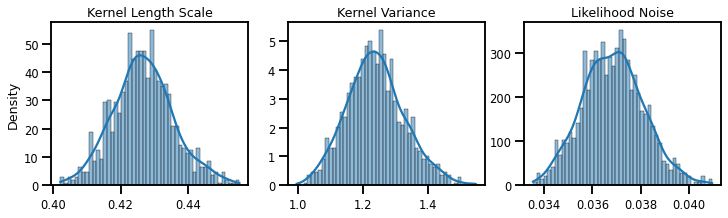

In [37]:
# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(
    ax=ax[0],
    x=posterior_params_samples["lengthscale"],
    kde=True,
    bins=50,
    stat="density",
)
sns.histplot(
    ax=ax[1], x=posterior_params_samples["variance"], kde=True, bins=50, stat="density"
)
sns.histplot(
    ax=ax[2], x=posterior_params_samples["obs_noise"], kde=True, bins=50, stat="density"
)

ax[0].set(title="Kernel Length Scale")
ax[1].set(title="Kernel Variance", ylabel="")
ax[2].set(title="Likelihood Noise", ylabel="")

plt.show()

### Median Parameters

In [38]:
def get_median_parameters(samples: dict) -> dict:
    median_params = {}
    for ikey, iarray in samples.items():
        median_params[ikey] = jnp.median(iarray)
    return median_params

In [39]:
median_params = get_median_parameters(posterior_params_samples)
pprint(median_params)

{'lengthscale': DeviceArray(0.42653491, dtype=float64),
 'obs_noise': DeviceArray(0.03683508, dtype=float64),
 'variance': DeviceArray(1.23494351, dtype=float64)}


### Predictions

In [40]:
from gpjax import mean, variance

meanf = mean(posterior, median_params, training_ds)
varf = variance(posterior, median_params, training_ds)


mu = meanf(xtest).squeeze()
cov = varf(xtest).squeeze()

one_stddev = 1.96 * jnp.sqrt(jnp.diag(cov))

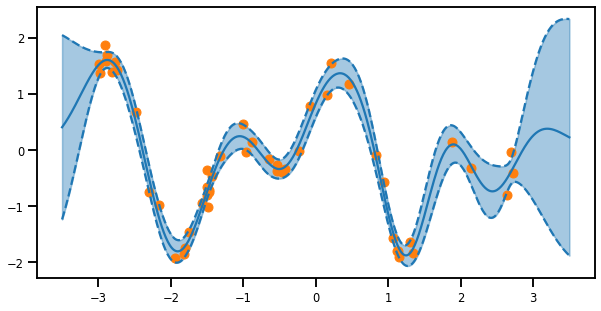

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

### All Posteriors

In [42]:
from gpjax import random_variable


def sample_posterior_from_params(rng, params, posterior, xtest, ds, n_samples=1):
    # create a random variable given parameters
    predictive_rv = random_variable(posterior, params, ds)(xtest)
    # sample from the rv
    return predictive_rv.sample(sample_shape=(n_samples,), seed=rng).squeeze()


# make the sampling faster
sample_posterior = jax.jit(
    jax.partial(
        sample_posterior_from_params,
        posterior=posterior,
        xtest=xtest,
        ds=training_ds,
        n_samples=1,
    )
)

In [43]:
# sample from the posterior
n_samples = 1_000
seed = 123

mcmc_posterior_samples = jax.vmap(sample_posterior, in_axes=(0, 0))(
    jax.random.split(jax.random.PRNGKey(seed), n_samples), posterior_params_samples
)
mcmc_posterior_samples.shape

(1000, 500)

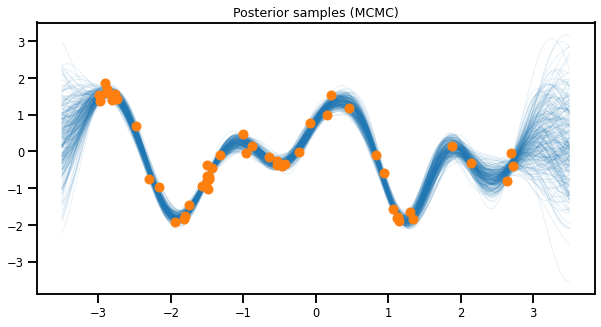

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(xtest, mcmc_posterior_samples[:250].T, color="tab:blue", alpha=0.1, lw=1)
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.set_title("Posterior samples (MCMC)")
plt.show()